In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg as LA
import gym
import os
import random
import sys
from gym import spaces
from gym.utils import seeding
import copy

from scipy.io import loadmat
import pandapower as pp
import pandapower.networks as pn
import pandas as pd 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import cvxpy as cp

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [13]:
A = -np.eye(12)
A[1,0]=1
A[2,0]=1
A[3,0]=1
A[4,1]=1
A[5,2]=1
A[6,2]=1
A[7,2]=1
A[8,3]=1
A[9,5]=1
A[10,5]=1
A[11,7]=1
# how this adjecent matrix is built:
# lines(rows):0-1,1-2,1-5,1-3,2-4,5-7,5-8,5-9,3-6,7-10,7-11,9-12
# buses (columns):1,2,5,3,4,7,8,9,6,10,11,12


In [3]:
A

array([[-1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 1., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 1., -0., -1., -0., -0., -0., -0., -0., -0., -0., -0., -0.],
       [ 1., -0., -0., -1., -0., -0., -0., -0., -0., -0., -0., -0.],
       [-0.,  1., -0., -0., -1., -0., -0., -0., -0., -0., -0., -0.],
       [-0., -0.,  1., -0., -0., -1., -0., -0., -0., -0., -0., -0.],
       [-0., -0.,  1., -0., -0., -0., -1., -0., -0., -0., -0., -0.],
       [-0., -0.,  1., -0., -0., -0., -0., -1., -0., -0., -0., -0.],
       [-0., -0., -0.,  1., -0., -0., -0., -0., -1., -0., -0., -0.],
       [-0., -0., -0., -0., -0.,  1., -0., -0., -0., -1., -0., -0.],
       [-0., -0., -0., -0., -0.,  1., -0., -0., -0., -0., -1., -0.],
       [-0., -0., -0., -0., -0., -0., -0.,  1., -0., -0., -0., -1.]])

In [42]:
X = np.diag([0.3856,0.1276,0.3856,0.1119,0.0765,0.0771,0.1928,0.0423,0.1119,0.0766,0.0766,0.0423])

In [43]:
F = -np.linalg.inv(A)

In [44]:
XX =2*F@X@F.T/np.square(4.16)

In [17]:
XX

array([[0.04456361, 0.04456361, 0.04456361, 0.04456361, 0.04456361,
        0.04456361, 0.04456361, 0.04456361, 0.04456361, 0.04456361,
        0.04456361, 0.04456361],
       [0.04456361, 0.05931028, 0.04456361, 0.04456361, 0.05931028,
        0.04456361, 0.04456361, 0.04456361, 0.04456361, 0.04456361,
        0.04456361, 0.04456361],
       [0.04456361, 0.04456361, 0.08912722, 0.04456361, 0.04456361,
        0.08912722, 0.08912722, 0.08912722, 0.04456361, 0.08912722,
        0.08912722, 0.08912722],
       [0.04456361, 0.04456361, 0.04456361, 0.05749584, 0.04456361,
        0.04456361, 0.04456361, 0.04456361, 0.05749584, 0.04456361,
        0.04456361, 0.04456361],
       [0.04456361, 0.05931028, 0.04456361, 0.04456361, 0.06815135,
        0.04456361, 0.04456361, 0.04456361, 0.04456361, 0.04456361,
        0.04456361, 0.04456361],
       [0.04456361, 0.04456361, 0.08912722, 0.04456361, 0.04456361,
        0.09803763, 0.08912722, 0.08912722, 0.04456361, 0.09803763,
        0.09803763,

In [8]:
Ybus = np.load('Ybus.npy')

In [6]:
np.max(np.linalg.eigvals(XX))
np.min(np.linalg.eigvals(XX))
# So XX is positive definite

0.0014869400199641902

In [45]:
XX_inv = np.linalg.inv(XX) 
print(np.min(np.linalg.eigvals(XX_inv)))

1.287614523467066


In [9]:
print(np.max(np.linalg.eigvals(XX_inv)))

672.5220833212135


In [67]:
from env_single_phase_13bus import IEEE13bus, create_13bus
net = create_13bus()
injection_bus = np.array([2,7,9])#1,2,5,3,4,7,8,9,6,10,11,12 //2,7,9
env = IEEE13bus(net, injection_bus)

In [47]:
env.network.bus

,name,vn_kv,type,zone,in_service,min_vm_pu,max_vm_pu
0,None,4.16,b,1.0,True,0.95,1.05
1,None,4.16,b,1.0,True,0.95,1.05
2,None,4.16,b,1.0,True,0.95,1.05
3,None,4.16,b,1.0,True,0.95,1.05
4,None,4.16,b,1.0,True,0.95,1.05
5,None,4.16,b,1.0,True,0.95,1.05
6,None,4.16,b,1.0,True,0.95,1.05
7,None,4.16,b,1.0,True,0.95,1.05
8,None,4.16,b,1.0,True,0.95,1.05
9,None,4.16,b,1.0,True,0.95,1.05


In [ ]:
#Suppose q = 0, then v(0) should be v^{par}
# thus the optimal solution q* = (C+X)^{-1}(v^{nom}-v^{par})

In [65]:
def cal_F(q, vpar, state, q_shape):
    delta_vpar = (np.square(vpar.reshape(q_shape))-np.ones_like(state.reshape(q_shape)))
    F_value = 0.5*q.T@C@q + 0.5*q.T@(np.square(state.reshape(q_shape))+np.square(vpar.reshape(q_shape))\
            -2*np.ones_like(state.reshape(q_shape))) #+ 0.5*delta_vpar.T@XX_inv@delta_vpar
    return F_value

In [66]:
# set the limitation of Q for 13 bus system (all buses are installed with an PV)
# Q_limit = np.asarray([[-0.5,0.3],[-0.5,0.3],[-0.5,0.3],[-0.4,0.2],[-0.4,0.2],[-0.4,0.2],[-0.2,0.2],[-0.2,0.2],[-0.2,0.2],[-0.2,0.2],[-0.3,0.2],[-0.2,0.2]])
Q_limit = np.asarray([[-1.0,1.0],[-1.0,0.8],[-1.0,0.6]])
def safe_flow(Q,action,alpha,limit,agent_num):
    #this version only works for single phase case
    solution = np.zeros_like(Q)
    for i in range(agent_num):
        if action[i]<0:
            action[i]=np.maximum(alpha*(limit[i,0]-Q[i]),action[i])
        elif action[i]>0:
            action[i]=np.minimum(alpha*(limit[i,1]-Q[i]),action[i])
    return action

In [7]:
def safe_flow(Q,action,alpha,limit,agent_num):
    #this version only works for single phase case
    solution = np.zeros_like(Q)
    for i in range(agent_num):
        if action[i]<0:
            action[i]=np.maximum(alpha*(limit[i,0]-Q[i]),action[i])
        elif action[i]>0:
            action[i]=np.minimum(alpha*(limit[i,1]-Q[i]),action[i])
    return action

In [55]:
print(num_agent)

12


In [69]:
max_ac = 0.5
ph_num = 1
slope = 2
num_agent = len(injection_bus)
alpha = 0.5
def test_suc_rate(algm, step_num=100,num_trail=5, alpha=0.9,linear = False):
    success_num = 0
    final_state_list = []
    final_step_list = []
    control_cost_list = []
    steady_cost_list = []
    F_list = []
    Q_consumption_list =[]
    action_traj = []
    real_action_traj = []
    all_state_list = []
    for rep in range(num_trail):
        state = env.reset(rep)
        if rep==9:
            print(state)
        episode_reward = 0
        last_action = np.zeros((num_agent,ph_num))
        action_list=[]
        state_list =[]
        state_list.append(state)
        vpar = state.copy()
        control_cost = []
        F_traj = []
        Q_consumption = []
        real_action = []
        for step in range(step_num):
            action_tmp = -slope*(np.maximum(state-1.04, np.zeros_like(state))-np.maximum(0.96-state, np.zeros_like(state))).reshape((num_agent,ph_num))
            action_list.append((action_tmp).copy())
            if linear:
                action_tmp = np.clip(action_tmp, -max_ac, max_ac)
            else:
                action_tmp = safe_flow(last_action,action_tmp,alpha,Q_limit,num_agent)
            # PI policy    
            action = last_action + np.asarray(action_tmp)
            Q_consumption.append(np.abs(action))
            # execute action a_t and observe reward r_t and observe next state s_{t+1}
            next_state, reward, reward_sep, done = env.step_Preward(action, (last_action-action))
            done = False
            
            real_action.append(action)
            state_list.append(next_state)
            last_action = np.copy(action)
            state = next_state

            control_cost.append(cal_F(action,vpar,state,(num_agent,ph_num)))
            F_traj.append(cal_F(action,vpar,state,(num_agent,ph_num)))
            if done:
                success_num += 1
                final_step_list.append(step+1)
                control_cost_list.append(np.sum(np.asarray(control_cost)))
                break
        
        if not done:
            final_step_list.append(step_num)
            control_cost_list.append(np.sum(np.asarray(control_cost)))
        # print(step+1)
        final_state_list.append(next_state)
        steady_cost = cal_F(action,vpar,state,(num_agent,ph_num))
        steady_cost_list.append(steady_cost)
        F_list.append(F_traj)
        Q_consumption_list.append(np.sum(np.asarray(Q_consumption)))
        real_action_traj.append(real_action)
        action_traj.append(action_list)
        all_state_list.append(state_list)
    print(f'result for {algm}')
    print(success_num)
    print(np.mean(final_step_list), np.std(final_step_list))
    print('Q consumption',np.mean(Q_consumption_list), np.std(Q_consumption_list))
    print('cost',np.mean(control_cost_list), np.std(control_cost_list))
    print('steady cost',np.mean(steady_cost_list), np.std(steady_cost_list))
    return final_state_list, F_list, real_action_traj,action_traj,all_state_list

In [51]:
import matplotlib
matplotlib.__version__

'3.6.2'

In [29]:
state_scenarios = []
action_scenarios = []
id = 9
for j in range(5):
    alpha = 0.2*(j+1)
    final_state, F_list,real_action_traj,action_traj,state_list = test_suc_rate('linear',20,10,alpha)
    state_scenarios.append(np.asarray(state_list[id])[:15,:])
    action_scenarios.append(np.asarray(real_action_traj[id])[:15,:])
final_state, F_list,real_action_traj,action_traj,state_list = test_suc_rate('linear',20,10,alpha,linear=True)
state_scenarios.append(np.asarray(state_list[id])[:15,:])
action_scenarios.append(np.asarray(real_action_traj[id])[:15,:])


[0.92567828 0.91833786 0.88499931 0.92205183 0.91605777 0.8765879
 0.88296922 0.87846093 0.92006701 0.87343228 0.86660377 0.87538667]
result for linear
0
20.0 0.0
Q consumption 25.672023670318346 9.455233889662876
cost -3.039205146732752 1.3230127296576026
steady cost -0.16384126167269936 0.07215859508178953
[0.92567828 0.91833786 0.88499931 0.92205183 0.91605777 0.8765879
 0.88296922 0.87846093 0.92006701 0.87343228 0.86660377 0.87538667]
result for linear
0
20.0 0.0
Q consumption 26.637367735207885 10.441888386897245
cost -3.162184920532773 1.4330730473976667
steady cost -0.16271925803089488 0.07357625558903391
[0.92567828 0.91833786 0.88499931 0.92205183 0.91605777 0.8765879
 0.88296922 0.87846093 0.92006701 0.87343228 0.86660377 0.87538667]
result for linear
0
20.0 0.0
Q consumption 26.557102058375392 10.353726220093522
cost -3.1884599656965786 1.4558689132657092
steady cost -0.16212206858589742 0.0731691841669182
[0.92567828 0.91833786 0.88499931 0.92205183 0.91605777 0.8765879
 0

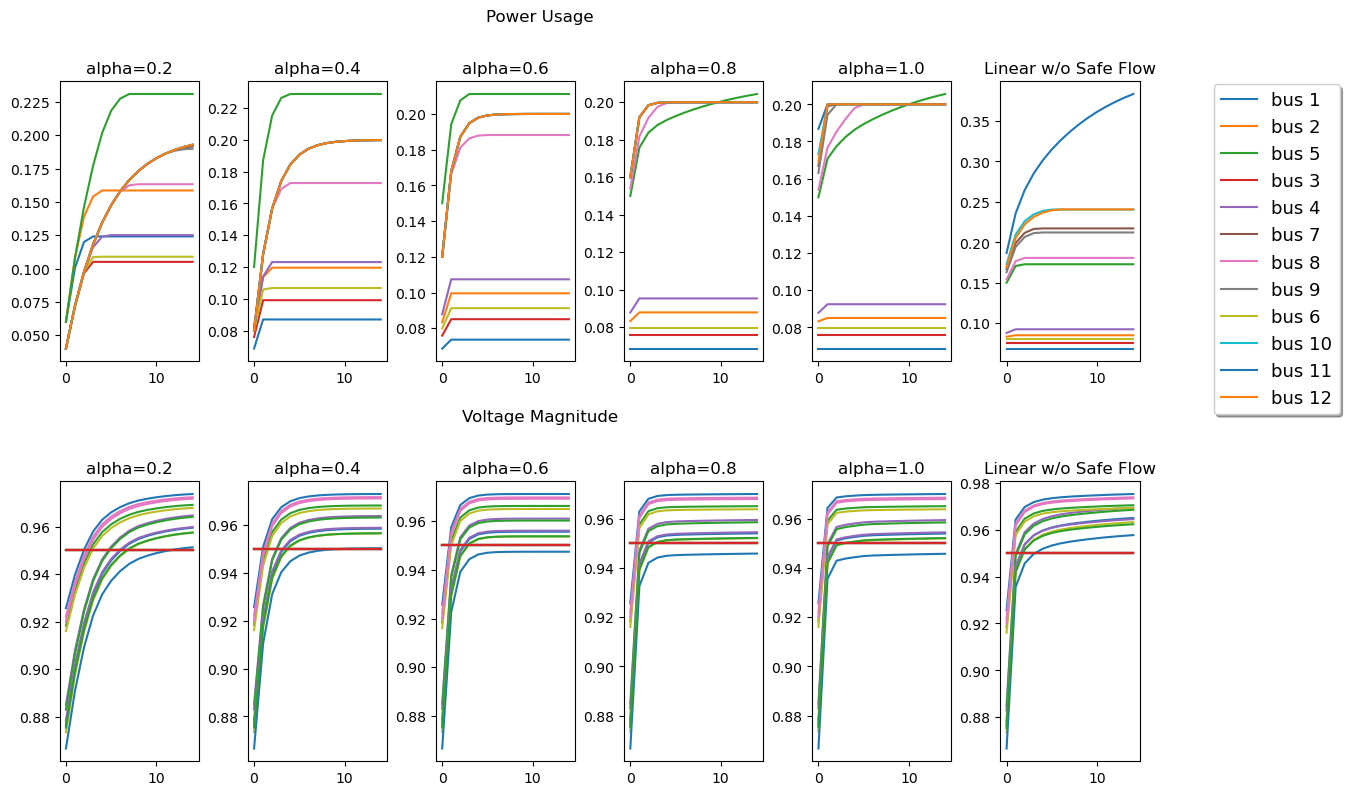

In [30]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Performance of Linear Controller with Safe Flow method')
plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=0.8, wspace=0.35, hspace=0.1)
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
subfigs[0].suptitle(f'Power Usage')
subfigs[1].suptitle(f'Voltage Magnitude')
axs0 = subfigs[0].subplots(nrows=1, ncols=6)
for i in range(num_agent):
    for j in range(6):
        axs0[j].plot(range(15),action_scenarios[j][:,i],label=f'bus {injection_bus[i]}')
        axs0[j].set_title(f'alpha={0.2*(j+1):.1f}')
        if j==5:
            axs0[j].set_title(f'Linear w/o Safe Flow')
axs1 = subfigs[1].subplots(nrows=1, ncols=6)
for i in range(num_agent):
    for j in range(6):
        axs1[j].plot(range(15),state_scenarios[j][:,i],label=f'bus {injection_bus[i]}')
        axs1[j].plot(range(15),np.ones_like(range(15))*0.95,label=f'bus {injection_bus[i]}')
        axs1[j].set_title(f'alpha={0.2*(j+1):.1f}')
        if j==5:
            axs1[j].set_title(f'Linear w/o Safe Flow')
axs0[5].legend(loc='right', bbox_to_anchor=(2.5, 0.4),
        fancybox=True, shadow=True, ncol=1, prop={"size":13})

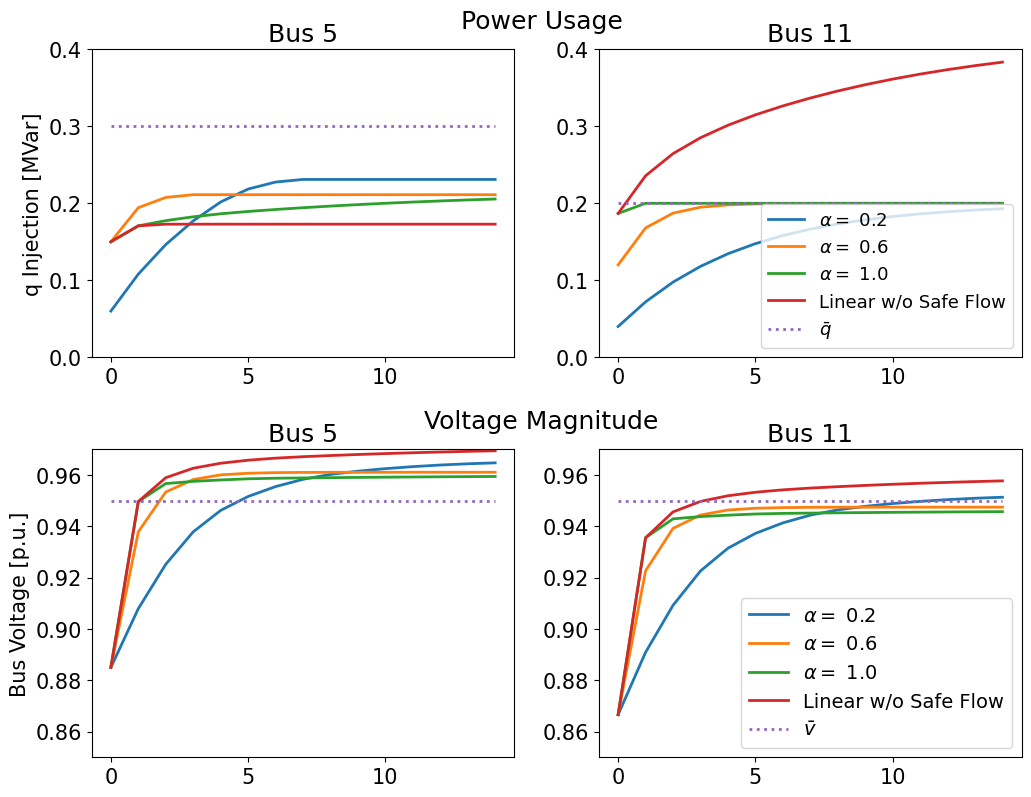

In [64]:
import matplotlib
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Performance of Linear Controller with Safe Flow method')
# plt.subplots_adjust(left=0.1, bottom=0.1, right=1, top=0.8, wspace=0.35, hspace=0.1)
# create 3x1 subfigs
subfigs = fig.subfigures(nrows=2, ncols=1)
subfigs[0].suptitle(f'Power Usage')
subfigs[1].suptitle(f'Voltage Magnitude')
axs0 = subfigs[0].subplots(nrows=1, ncols=2)
axs0[0].set_ylim([0, 0.4])
axs0[1].set_ylim([0, 0.4])
for i in range(3):
    j = 2*i
    axs0[0].plot(range(15),action_scenarios[j][:,2],label=r'$\alpha=$'+f' {0.2+j*0.2:.1f}', linewidth=2)
    axs0[1].plot(range(15),action_scenarios[j][:,10],label=r'$\alpha=$'+f' {0.2+j*0.2:.1f}', linewidth=2)
axs0[0].plot(range(15),action_scenarios[5][:,2],label='Linear w/o Safe Flow', linewidth=2)
axs0[1].plot(range(15),action_scenarios[5][:,10],label='Linear w/o Safe Flow', linewidth=2)
axs0[0].plot(range(15),np.ones_like(range(15))*0.3,label=r'$\bar{q}$', linestyle='dotted', linewidth=2)
axs0[1].plot(range(15),np.ones_like(range(15))*0.2,label=r'$\bar{q}$', linestyle='dotted', linewidth=2)
axs0[0].set_title('Bus 5')
axs0[1].set_title('Bus 11')
axs0[0].set_ylabel('q Injection [MVar]')  
axs1 = subfigs[1].subplots(nrows=1, ncols=2)

for i in range(3):
    j = 2*i
    axs1[0].plot(range(15),state_scenarios[j][:,2],label=r'$\alpha=$'+f' {0.2+j*0.2:.1f}', linewidth=2)
    axs1[1].plot(range(15),state_scenarios[j][:,10],label=r'$\alpha=$'+f' {0.2+j*0.2:.1f}', linewidth=2)
axs1[0].plot(range(15),state_scenarios[5][:,2],label='Linear w/o Safe Flow', linewidth=2)
axs1[1].plot(range(15),state_scenarios[5][:,10],label='Linear w/o Safe Flow', linewidth=2)
axs1[0].plot(range(15),np.ones_like(range(15))*0.95,label=r'$\bar{v}$', linestyle='dotted', linewidth=2)
axs1[1].plot(range(15),np.ones_like(range(15))*0.95,label=r'$\bar{v}$', linestyle='dotted', linewidth=2)
axs1[0].set_title('Bus 5')
axs1[1].set_title('Bus 11')
axs1[0].set_ylabel('Bus Voltage [p.u.]')   
axs1[0].set_ylim([0.85, 0.97])
axs1[1].set_ylim([0.85, 0.97])
matplotlib.rcParams.update({'font.size': 15})
# axs0[0].legend(prop={"size":13})
axs0[1].legend(prop={"size":13},loc='lower right')
# axs1[0].legend(prop={"size":13})
axs1[1].legend(prop={"size":14})



In [184]:
final_state, F_list,real_action_traj,action_traj,state_list = test_suc_rate('linear',100,10,alpha=0.2)
# basic linear controller

[0.92463143 0.91931575 0.88205201 0.92088229 0.91759115 0.87273629
 0.87977549 0.8767625  0.9187765  0.86956659 0.86270699 0.87368224]
result for linear
0
100.0 0.0
Q consumption 144.83423429162428 47.30321649421138
cost -16.43764840822227 6.649213642115897
steady cost -0.16661012917153487 0.06776551794396408


In [164]:

action_traj = np.asarray(action_traj)
# print(action_traj[3,:,10])
for i in range(49):
    action_traj[:,i+1]+=action_traj[:,i]

result for linear
0
50.0 0.0
Q consumption 76.66715430030493 13.03217364841084
cost -8.832485368713256 2.3101776145782447
steady cost -0.18841016890893011 0.05181548909907798
result for linear
0
50.0 0.0
Q consumption 79.70804514788604 14.82091964584728
cost -9.12051512673355 2.489650032240278
steady cost -0.18734330732448728 0.0520215445910861
result for linear
0
50.0 0.0
Q consumption 79.89238968028141 15.119748608221965
cost -9.175174255825766 2.5354056025103033
steady cost -0.18636634653408007 0.051771057999972656
result for linear
0
50.0 0.0
Q consumption 79.41776454257072 15.001299770968457
cost -9.170081365497238 2.543472968564527
steady cost -0.1852959669877103 0.05136478344905158
result for linear
0
50.0 0.0
Q consumption 78.81989177963061 14.66487727489109
cost -9.14720555771029 2.53543346874221
steady cost -0.18430824813604843 0.050874210889607585
result for linear
0
50.0 0.0
Q consumption 78.07088121759796 14.217874796116854
cost -9.112667165185574 2.5164097219243784
steady

Text(0, 0.5, 'reactive power')

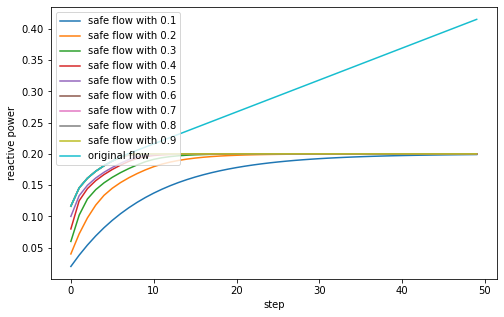

In [174]:
fig = plt.gcf()
fig.set_size_inches(8, 5)

for j in range(9):
    alpha = 0.1*(j+1)
    final_state, F_list,real_action_traj,action_traj = test_suc_rate('linear',50,5,alpha)
    action_traj = np.asarray(action_traj)
    for i in range(49):
        action_traj[:,i+1]+=action_traj[:,i]
    plt.plot(range(50),np.asarray(real_action_traj)[3,:,10],label=f'safe flow with 0.{j+1}')
    if j==8:
        plt.plot(range(50),np.asarray(action_traj)[3,:,10],label=f'original flow')
plt.legend()
plt.xlabel('step')
plt.ylabel('reactive power')

[9.76500000e-01 2.26666667e-02 8.33333333e-04 0.00000000e+00
 0.00000000e+00]


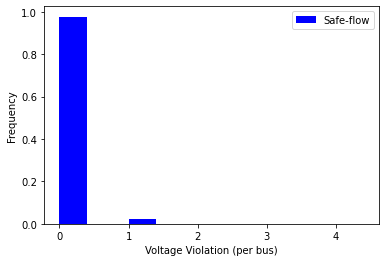

In [61]:
state_list = np.abs(np.asarray(final_state)-1)
marks = [0,0,0,0,0]
marks[0]=np.sum(state_list<0.05)
marks[1]=np.sum(state_list<0.07)-marks[0]
marks[2]=np.sum(state_list<0.09)-marks[1]-marks[0]
marks[3]=np.sum(state_list<0.1)-marks[1]-marks[0]-marks[2]
marks[4]=len(state_list)*num_agent-marks[1]-marks[0]-marks[2]-marks[3]
marks = np.array(marks)/len(state_list)/num_agent
print(marks)
xlab = 'Voltage Violation (per bus)'

bars=('Stable','5-7%','7-9%','9-10%','>10%')
y=np.arange(len(bars))
plt.bar(y+0.2,marks, 0.4,color='b',label='Safe-flow')
plt.xlabel(xlab)
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.show()

In [70]:
# C = np.diag([0.5,0.7,0.5,0.7,1.0,0.7,1.0,0.7,1.0,1.0,1.0,1.0])*0.25
C = np.diag([0.7,0.5,0.6])*0.15
# C = np.eye(num_agent)*0.01

In [71]:
def test_suc_rate_grad(algm, step_num=100,gamma=0.5,num_trail=500,alpha=0.5):
    success_num = 0
    final_state_list = []
    final_step_list = []
    control_cost_list = []
    steady_cost_list = []
    vpar = np.zeros(num_agent)
    F_list = []
    Q_consumption_list =[]
    for rep in range(num_trail):
        state = env.reset(rep)
        episode_reward = 0
        last_action = np.zeros((num_agent,ph_num))
        action_list=[]
        state_list =[]
        state_list.append(state)
        control_action = []
        vpar = state.copy()
        action_tmp = np.zeros((num_agent,ph_num))
        F_traj = []
        Q_consumption = []
        for step in range(step_num):
            action_tmp = -gamma*(C@last_action + np.square(state.reshape((num_agent,ph_num))) - np.ones_like(last_action))
            action_tmp = safe_flow(last_action,action_tmp,alpha,Q_limit,num_agent)
            
            # action_tmp = np.clip(action_tmp, -max_ac, max_ac)
            # PI policy    
            action = last_action + action_tmp
            Q_consumption.append(np.abs(action))
            # execute action a_t and observe reward r_t and observe next state s_{t+1}
            next_state, reward, reward_sep, done = env.step_Preward(action, (last_action-action))
            
            done = False
            action_list.append(last_action-action)
            state_list.append(next_state)
            last_action = np.copy(action)
            state = next_state

            control_action.append(cal_F(action,vpar,state,(num_agent,ph_num)))
            F_traj.append(cal_F(action,vpar,state,(num_agent,ph_num)))
            if done:
                success_num += 1
                final_step_list.append(step+1)
                control_cost_list.append(np.sum(np.asarray(control_action)))
                break
            
        # error = np.linalg.norm(action- np.linalg.inv(C+XX)@(np.ones((num_agent,ph_num))-np.square(vpar.reshape((num_agent,ph_num)))))
        
        if not done:
            final_step_list.append(step_num)
            control_cost_list.append(np.sum(np.asarray(control_action)))
        final_state_list.append(next_state)
        steady_cost = cal_F(action,vpar,state,(num_agent,ph_num))
        steady_cost_list.append(steady_cost)
        F_list.append(F_traj)
        Q_consumption_list.append(np.sum(np.asarray(Q_consumption)))
        # print(action)
        # print(np.square(state))
        
    print(f'result for {algm}')
    print(success_num)
    print(np.mean(final_step_list), np.std(final_step_list))
    print('cost',np.mean(control_cost_list), np.std(control_cost_list))
    # print('cost',control_cost_list, np.std(control_cost_list))
    print('Q consumption',np.mean(Q_consumption_list), np.std(Q_consumption_list))
    print('steady cost',np.mean(steady_cost_list), np.std(steady_cost_list))
    return final_state_list,vpar,state,action,F_list

In [18]:
vpar= env.reset(0)
print(vpar)
q_desired = np.linalg.inv(C+XX)@(np.ones_like(vpar)-np.square(vpar))
print(q_desired)
print(XX@q_desired+np.square(vpar))


[0.92585839 0.91864506 0.8888552  0.92156768 0.91709517 0.88098604
 0.88663004 0.88331663 0.91924787 0.87861546 0.87186315 0.88107549]
[0.25868975 0.22771822 0.27130542 0.20379088 0.16495018 0.24059348
 0.13906147 0.23822014 0.15187844 0.17877022 0.22443237 0.17906946]
[0.96766378 0.96014931 0.96608682 0.9643366  0.95876246 0.95789614
 0.96523463 0.95831148 0.96203039 0.95530745 0.94389191 0.95523263]


result for grad
0
100.0 0.0
cost -10.772218428063345 6.393905711535754
Q consumption 132.04657164285047 39.09813223613466
steady cost -0.10880718597383716 0.0646084143373144


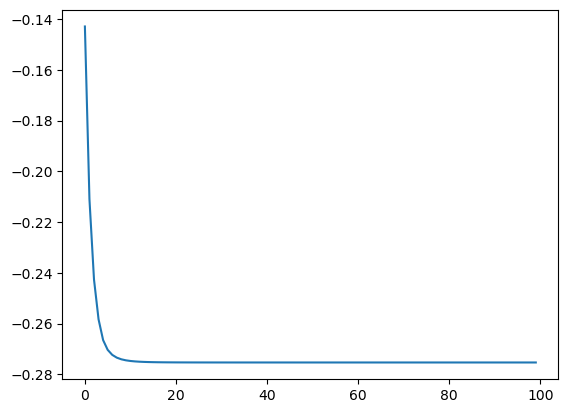

In [34]:
final_state_grad,vpar,state,action, F_list = test_suc_rate_grad('grad',100,1,500)
test_id = 0
plt.plot(range(np.squeeze(F_list[test_id]).shape[0]),np.squeeze(F_list[test_id]))

In [224]:
alpha = 0.7
def test_suc_rate_grad_and_linear(algm, step_num=100,gamma=0.5, num_trail=500):
    success_num = 0
    final_state_list = []
    final_step_list = []
    control_cost_list = []
    steady_cost_list = []
    vpar = np.zeros(num_agent)
    Q_consumption_list =[]
    for rep in range(num_trail):
        state = env.reset(rep)
        episode_reward = 0
        last_action = np.zeros((num_agent,ph_num))
        action_list=[]
        state_list =[]
        state_list.append(state)
        control_action = []
        vpar = state.copy()
        action_tmp = np.zeros((num_agent,ph_num))
        Q_consumption = []
        for step in range(step_num):
            action_tmp = -slope*(np.maximum(state-1.03, np.zeros_like(state))-np.maximum(0.97-state, np.zeros_like(state))).reshape((num_agent,ph_num))
            action_tmp = safe_flow(last_action,action_tmp,alpha,Q_limit,num_agent)
            action_tmp += -gamma*(C@last_action + np.square(state.reshape((num_agent,ph_num))) - np.ones_like(last_action))
            
            action_tmp = safe_flow(last_action,action_tmp,alpha,Q_limit,num_agent)
            # action_tmp = np.clip(action_tmp, -max_ac, max_ac)
            # PI policy    
            action = last_action + action_tmp
            Q_consumption.append(np.abs(action))
            # execute action a_t and observe reward r_t and observe next state s_{t+1}
            next_state, reward, reward_sep, done = env.step_Preward(action, (last_action-action))
            # done = False
            action_list.append(last_action-action)
            state_list.append(next_state)
            last_action = np.copy(action)
            state = next_state
            control_action.append(cal_F(action,vpar,state,(num_agent,ph_num)))
            if done:
                success_num += 1
                final_step_list.append(step+1)
                control_cost_list.append(np.sum(np.asarray(control_action)))
                break
        # error = np.linalg.norm(action- np.linalg.inv(C+XX)@(np.ones((num_agent,ph_num))-np.square(vpar.reshape((num_agent,ph_num)))))
        # print(np.linalg.norm(C@last_action + state.reshape((num_agent,ph_num)) - np.ones_like(last_action)))
        # print(error)
        
        if not done:
            final_step_list.append(step_num)
            control_cost_list.append(np.sum(np.asarray(control_action)))
        final_state_list.append(next_state)
        # print(action.T.shape)
        steady_cost = cal_F(action,vpar,state,(num_agent,ph_num))
        steady_cost_list.append(steady_cost)
        Q_consumption_list.append(np.sum(np.asarray(Q_consumption)))
        # print(action)
        # print(state)
        
    print(f'result for {algm} + grad')
    print(success_num)
    print(np.mean(final_step_list), np.std(final_step_list))
    print('cost',np.mean(control_cost_list), np.std(control_cost_list))
    print('Q consumption',np.mean(Q_consumption_list), np.std(Q_consumption_list))
    # print('cost',control_cost_list, np.std(control_cost_list))
    print('steady cost',np.mean(steady_cost_list), np.std(steady_cost_list))
    return final_state_list,vpar,state,action

In [225]:
final_state_grad,vpar,state,action = test_suc_rate_grad_and_linear('linear',100,0.5,500)

result for linear + grad
497
1.88 7.6402617756199955
cost -0.45912598983767045 2.8782185716608892
Q consumption 3.8779203147133163 20.63243091737127
steady cost -0.16381861592594277 0.0806149033205798


In [309]:
q = np.linalg.inv(C+XX)@(np.ones((num_agent,ph_num))-np.square(vpar.reshape((num_agent,ph_num))))
state_desired = np.sqrt(XX@q+np.square(vpar.reshape((num_agent,ph_num))))
F_value = 0.5*q.T@C@q + 0.5*q.T@XX@q  + q.T@(np.square(vpar.reshape((num_agent,ph_num)))-np.ones_like(state.reshape((num_agent,ph_num))))

In [285]:
deno = max(np.linalg.eigvals(XX+C))
print(deno)


0.9882848208461907


In [152]:
up = 2*np.sqrt(min(np.linalg.eigvals(XX.T@XX)))
print(up)

0.05146477841898024


In [228]:
print(2/deno)

2.023708102981443


In [155]:
deno = 3*max(np.linalg.eigvals(C@XX_inv+np.eye(XX.shape[0])))
print(deno)

10.996106309938034


In [157]:
print(2/deno)

0.18188256312076984


In [286]:
up = 2*min(np.linalg.eigvals(XX))
print(up)

0.0029738800399283804


In [288]:
deno = 3*(up+0.25)

In [289]:
print(up/deno)

0.003918560076187833


# Now suppose the X matrix is unknown, we consider not fully installed with PVs. 

In [2]:
from env_single_phase_123bus import IEEE123bus, create_123bus

net_123 = create_123bus()

injection_bus_123 = np.array([10, 11, 16, 20, 33, 36, 48, 59, 66, 75, 83, 92, 104, 61])-1 
env_123 = IEEE123bus(net_123, injection_bus_123)
s = env_123.reset()

In [73]:
Q_limit_123 = np.asarray([[-15,15],[-10,10],[-13,13],[-7,7],[-6,6],[-3.5,3.5],[-7,7],[-2.5,2.5],[-3,3],[-4.5,4.5],[-1.5,1.5],[-3,3],[-2.4,2.4],[-1.2,1.2]])
alpha = 0.5

In [3]:
max_ac = 0.8
ph_num = 1
slope = 5
num_agent = len(injection_bus_123)
def test_suc_rate_123(algm, step_num=100,num_trail=500):
    success_num = 0
    final_state_list = []
    final_step_list = []
    control_cost_list = []
    steady_cost_list = []
    F_list = []
    Q_consumption_list =[]
    for rep in range(num_trail):
        state = env_123.reset(rep)
        episode_reward = 0
        last_action = np.zeros((num_agent,ph_num))
        action_list=[]
        state_list =[]
        state_list.append(state)
        vpar = state.copy()
        control_cost = []
        F_traj = []
        Q_consumption = []
        for step in range(step_num):
            action_tmp = -slope*(np.maximum(state-1.03, np.zeros_like(state))-np.maximum(0.97-state, np.zeros_like(state))).reshape((num_agent,ph_num))
            action_tmp = safe_flow(last_action,action_tmp,alpha,Q_limit_123,num_agent)
            # action_tmp = np.clip(action_tmp, -max_ac, max_ac)
            # PI policy    
            action = last_action + np.asarray(action_tmp)
            Q_consumption.append(np.abs(action))
            # execute action a_t and observe reward r_t and observe next state s_{t+1}
            next_state, reward, reward_sep, done = env_123.step_Preward(action, (last_action-action))
            done = False
            
            action_list.append(last_action-action)
            state_list.append(next_state)
            last_action = np.copy(action)
            state = next_state
            if done:
                success_num += 1
                final_step_list.append(step+1)
                control_cost_list.append(np.sum(np.asarray(control_cost)))
                break

            control_cost.append(cal_F(action,vpar,state,(num_agent,ph_num)))
            F_traj.append(cal_F(action,vpar,state,(num_agent,ph_num)))
        if not done:
            final_step_list.append(step_num)
            control_cost_list.append(np.sum(np.asarray(control_cost)))
        final_state_list.append(next_state)
        steady_cost = cal_F(action,vpar,state,(num_agent,ph_num))
        steady_cost_list.append(steady_cost)
        Q_consumption_list.append(np.sum(np.asarray(Q_consumption)))
        F_list.append(F_traj)
    print(f'result for {algm}')
    print(success_num)
    print(np.mean(final_step_list), np.std(final_step_list))
    print('Q consumption',np.mean(Q_consumption_list), np.std(Q_consumption_list))
    print('cost',np.mean(control_cost_list), np.std(control_cost_list))
    print('steady cost',np.mean(steady_cost_list), np.std(steady_cost_list))
    return final_state_list, F_list

In [22]:
Q_limit_123 = np.asarray([[-21.6,21.6],[-18,18],[-21.6,21.6],[-10.8,10.8],[-9.45,9.45],[-20,20],[-20,20],[-16,16],[-4.725,4.725],[-7.2,7.2],[-7.2,7.2],[-6.75,6.75],[-6.75,6.75],[-5.4,5.4]])
# C = np.diag([0.1,0.2,0.3,0.3,0.5,0.7,1.0,0.7,1.0,1.0,1.0,1.0,0.5,0.7])*0.025
C = np.diag([0.2,0.25,0.1,0.3,0.3,0.2,0.2,0.3,0.9,0.7,0.7,0.7,0.6,0.7])*0.02
alpha=0.5
def cal_F(q, vpar, state, q_shape):
    delta_vpar = (np.square(vpar.reshape(q_shape))-np.ones_like(state.reshape(q_shape)))
    F_value = 0.5*q.T@C@q + 0.5*q.T@(np.square(state.reshape(q_shape))+np.square(vpar.reshape(q_shape))\
            -2*np.ones_like(state.reshape(q_shape))) #+ 0.5*delta_vpar.T@XX_inv@delta_vpar
    return F_value

result for linear
0
100.0 0.0
Q consumption 4298.203238455504 759.0144147793663
cost -392.1836322814012 97.88063181219489
steady cost -4.587300702715629 1.125753351158101


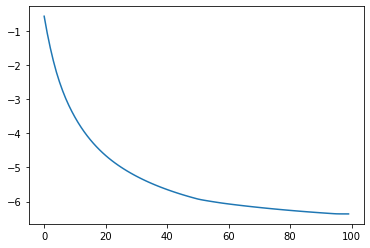

In [238]:
final_state, F_list = test_suc_rate_123('linear',100)
plt.plot(range(len(F_list[0])),np.squeeze(F_list[0]))

In [20]:
def test_suc_rate_grad_123(algm, step_num=100,gamma=0.5,num_trail=500):
    success_num = 0
    final_state_list = []
    final_step_list = []
    control_cost_list = []
    steady_cost_list = []
    vpar = np.zeros(num_agent)
    F_list = []
    Q_consumption_list =[]
    for rep in range(num_trail):
        state = env_123.reset(rep)
        episode_reward = 0
        last_action = np.zeros((num_agent,ph_num))
        action_list=[]
        state_list =[]
        state_list.append(state)
        control_action = []
        vpar = state.copy()
        action_tmp = np.zeros((num_agent,ph_num))
        F_traj = []
        Q_consumption = []
        for step in range(step_num):
            action_tmp = -gamma*(C@last_action + np.square(state.reshape((num_agent,ph_num))) - np.ones_like(last_action))
            action_tmp = safe_flow(last_action,action_tmp,alpha,Q_limit_123,num_agent)
            # action_tmp = np.clip(action_tmp, -max_ac, max_ac)
            # PI policy    
            action = last_action + action_tmp
            Q_consumption.append(np.abs(action))
            # execute action a_t and observe reward r_t and observe next state s_{t+1}
            next_state, reward, reward_sep, done = env_123.step_Preward(action, (last_action-action))
            
            done = False
            
            action_list.append(last_action-action)
            state_list.append(next_state)
            last_action = np.copy(action)
            state = next_state
            if done:
                success_num += 1
                final_step_list.append(step+1)
                control_cost_list.append(np.sum(np.asarray(control_action)))
                break
            # print(state.shape)
            control_action.append(cal_F(action,vpar,state,(num_agent,ph_num)))
            F_traj.append(cal_F(action,vpar,state,(num_agent,ph_num)))
            
        
        if not done:
            final_step_list.append(step_num)
            control_cost_list.append(np.sum(np.asarray(control_action)))
        final_state_list.append(next_state)
        steady_cost = cal_F(action,vpar,state,(num_agent,ph_num))
        steady_cost_list.append(steady_cost)
        F_list.append(F_traj)
        Q_consumption_list.append(np.sum(np.asarray(Q_consumption)))
        
    print(f'result for {algm}')
    print(success_num)
    print(np.mean(final_step_list), np.std(final_step_list))
    print('Q consumption',np.mean(Q_consumption_list), np.std(Q_consumption_list))
    print('cost',np.mean(control_cost_list), np.std(control_cost_list))
    # print('cost',control_cost_list, np.std(control_cost_list))
    print('steady cost',np.mean(steady_cost_list), np.std(steady_cost_list))
    return final_state_list,vpar,state,action,F_list

result for grad
0
500.0 0.0
Q consumption 34765.78501993911 3984.125469064367
cost -2788.368593996596 622.2171143296747
steady cost -5.946829126840547 1.3435728777486973


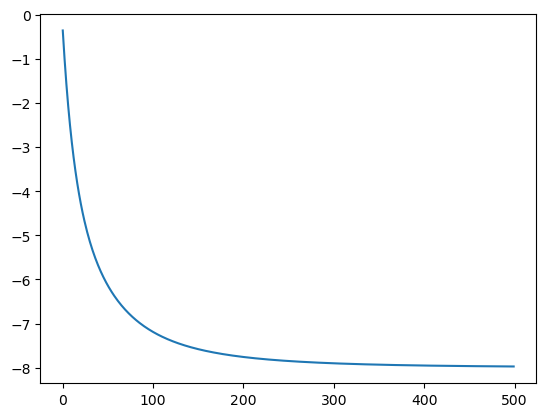

In [21]:
final_state_grad,vpar,state,action, F_list = test_suc_rate_grad_123('grad',500,1,500)
plt.plot(range(len(F_list[0])),np.squeeze(F_list[0]))

In [235]:
def test_suc_rate_grad_and_linear_123(algm, step_num=100,gamma=0.5, num_trail=500):
    success_num = 0
    final_state_list = []
    final_step_list = []
    control_cost_list = []
    steady_cost_list = []
    vpar = np.zeros(num_agent)
    F_list = []
    Q_consumption_list =[]
    for rep in range(num_trail):
        state = env_123.reset(rep)
        episode_reward = 0
        last_action = np.zeros((num_agent,ph_num))
        action_list=[]
        state_list =[]
        state_list.append(state)
        control_action = []
        vpar = state.copy()
        action_tmp = np.zeros((num_agent,ph_num))
        F_traj = []
        Q_consumption = []
        for step in range(step_num):
            action_tmp = -slope*(np.maximum(state-1.03, np.zeros_like(state))-np.maximum(0.97-state, np.zeros_like(state))).reshape((num_agent,ph_num))
            action_tmp = safe_flow(last_action,action_tmp,alpha,Q_limit_123,num_agent)
            action_tmp += -gamma*(C@last_action + np.square(state.reshape((num_agent,ph_num))) - np.ones_like(last_action))
            
            action_tmp = safe_flow(last_action,action_tmp,alpha,Q_limit_123,num_agent)
            # PI policy    
            action = last_action + action_tmp
            Q_consumption.append(np.abs(action))
            # execute action a_t and observe reward r_t and observe next state s_{t+1}
            next_state, reward, reward_sep, done = env_123.step_Preward(action, (last_action-action))
            done = False
            if done:
                success_num += 1
                final_step_list.append(step+1)
                control_cost_list.append(np.sum(np.asarray(control_action)))
                break
            action_list.append(last_action-action)
            state_list.append(next_state)
            last_action = np.copy(action)
            state = next_state

            control_action.append(cal_F(action,vpar,state,(num_agent,ph_num)))
            F_traj.append(cal_F(action,vpar,state,(num_agent,ph_num)))
    
        if not done:
            final_step_list.append(step_num)
            control_cost_list.append(np.sum(np.asarray(control_action)))
        final_state_list.append(next_state)
        # print(action.T.shape)
        steady_cost = cal_F(action,vpar,state,(num_agent,ph_num))
        steady_cost_list.append(steady_cost)
        F_list.append(F_traj)
        Q_consumption_list.append(np.sum(np.asarray(Q_consumption)))
        # print(action)
        # print(state)
        
    print(f'result for {algm} + grad')
    print(success_num)
    print(np.mean(final_step_list), np.std(final_step_list))
    print('Q consumption',np.mean(Q_consumption_list), np.std(Q_consumption_list))
    print('cost',np.mean(control_cost_list), np.std(control_cost_list))
    # print('cost',control_cost_list, np.std(control_cost_list))
    print('steady cost',np.mean(steady_cost_list), np.std(steady_cost_list))
    return final_state_list,vpar,state,action, F_list

In [45]:
print(action)

[[12.05129828]
 [ 9.42598986]
 [ 8.29749896]
 [ 6.75548468]
 [ 5.05153458]
 [ 3.12832077]
 [ 2.68439276]
 [ 2.72344532]
 [ 3.79561417]
 [ 2.71280363]
 [ 1.87794201]
 [ 2.20122551]
 [ 2.97532373]
 [ 2.52840744]]


result for linear + grad
0
100.0 0.0
Q consumption 5020.719695944481 652.9661073955253
cost -438.16178497412545 99.60435354669399
steady cost -4.910145396688412 1.0686553304913826


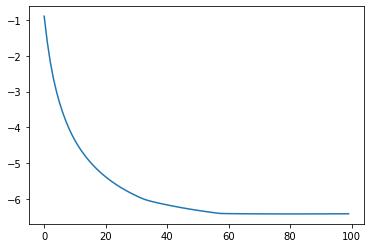

In [236]:
final_state_grad,vpar,state,action,F_list = test_suc_rate_grad_and_linear_123('linear',100,1,500)
plt.plot(range(len(F_list[0])),np.squeeze(F_list[0]))